# Neural Language Model and Spinoza's Ethics

In this post I will show how to build a language model for text generation using deep learning techniques.


## Introduction

Though natural language, in principle, have formal structures and grammar, in practice it is full of ambiguities. Modeling it using examples and modeling is an interesting alternative.  The definition of a (statistical) language model given by [Ref.1](https://en.wikipedia.org/wiki/Language_model) is:

> A statistical language model is a probability distribution over sequences of words. Given such a sequence it assigns a probability to the whole sequence.

Or equivalently, given a sequence $\{w_1,...,w_n\}$ of length $m$, the model assigns a probability 

$$P(w_1,...,w_n)$$

to the whole sequence. In particular, a neural language model can predict the probability of the next word in a sentence (see [Ref.2](https://machinelearningmastery.com/develop-character-based-neural-language-model-keras/) for more details). 

The use of neural networks has become one of the main approaches to language modeling. Three properties can describe this neural language modeling (NLM) approach succinctly [Ref. 3](http://www.jmlr.org/papers/v3/bengio03a.html): 

> We first associate words in the vocabulary with a distributed word feature vector, then express the joint probability function of word sequences in terms of the feature vectors of these words in the sequence and then learn simultaneously the word feature vector and the parameters of the probability function. 

In this project I used Spinoza's *Ethics* to build a NLM.

## *The Ethics*

From [Ref.4](https://en.wikipedia.org/wiki/Ethics_(Spinoza)):

> Ethics, Demonstrated in Geometrical Order, usually known as the Ethics, is a philosophical treatise written by Benedict de Spinoza. 

The article goes on to say that:

> The book is perhaps the most ambitious attempt to apply the method of Euclid in philosophy. Spinoza puts forward a small number of definitions and axioms from which he attempts to derive hundreds of propositions and corollaries [...]

The book has structure shown below. We see that it is set out in geometrical form paralleling the "canonical example of a rigorous structure of argument producing unquestionable results: the example being the geometry of Euclid" (see [link](https://timlshort.com/2010/06/21/spinozas-style-of-argument-in-ethics-i/)).

> # PART I. CONCERNING GOD. 
## DEFINITIONS.
I. By that which is self—caused, I mean that of which the essence involves existence, or that of which the nature is only conceivable as existent.

> II. A thing is called finite after its kind, when it can be limited by another thing of the same nature; for instance, a body is called finite because we always conceive another greater body. So, also, a thought is limited by another thought, but a body is not limited by thought, nor a thought by body.

> III. By substance, I mean that which is in itself, and is conceived through itself: in other words, that of which a conception can be formed independently of any other conception.

> IV. By attribute, I mean that which the intellect perceives as constituting the essence of substance.”


### Imports

In [33]:
from numpy import array
from pickle import dump
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

/Users/marcotavora/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### We first write a function to load texts

The steps of the function below are:
- Opens the file 'ethics.txt'
- Reads it into a string
- Closes it

In [1]:
file = "ethics.txt"

In [2]:
def load_txt(file):
    f = open(file, 'r')
    text = f.read()
    f.close()
    return text

### Priting out part of the string

We see it contains lots of new line characters.

In [3]:
load_txt(file)[0:100]

'PART I. CONCERNING GOD.\n\nDEFINITIONS.\n\n\nI.  By that which is self--caused, I mean that of which the\n'

### Loading and splitting the string

In [4]:
raw = load_txt('ethics.txt')

In [5]:
raw[0:100]

'PART I. CONCERNING GOD.\n\nDEFINITIONS.\n\n\nI.  By that which is self--caused, I mean that of which the\n'

## Preprocessing

The first step is tokenization. With the tokens we will be able to train our model. Some other actions are:
- Exclude stopwords (common words, adding no meaning such as for example, "I", "am")
- Take out punctuation and spaces
- Convert text to lower case
- Split words (on white spaces)
- Elimitate `--`,`"`, numbers and brackets
- Dropping non-alphabetic words
- Stemming




In [6]:
import nltk
# nltk.download('stopwords')
  
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

def cleaner(text):
    stemmer = PorterStemmer()
    stop = stopwords.words('english') 
    text = text.replace('[',' ').replace(']',' ').replace('--', ' ')
    tokens = text.split()
    text = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(text) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [7]:
print(cleaner(raw)[0:100])

['part', 'i', 'concerning', 'god', 'definitions', 'i', 'by', 'that', 'which', 'is', 'self', 'caused', 'i', 'mean', 'that', 'of', 'which', 'the', 'essence', 'involves', 'existence', 'or', 'that', 'of', 'which', 'the', 'nature', 'is', 'only', 'conceivable', 'as', 'existent', 'ii', 'a', 'thing', 'is', 'called', 'finite', 'after', 'its', 'kind', 'when', 'it', 'can', 'be', 'limited', 'by', 'another', 'thing', 'of', 'the', 'same', 'nature', 'for', 'instance', 'a', 'body', 'is', 'called', 'finite', 'because', 'we', 'always', 'conceive', 'another', 'greater', 'body', 'so', 'also', 'a', 'thought', 'is', 'limited', 'by', 'another', 'thought', 'but', 'a', 'body', 'is', 'not', 'limited', 'by', 'thought', 'nor', 'a', 'thought', 'by', 'body', 'iii', 'by', 'substance', 'i', 'mean', 'that', 'which', 'is', 'in', 'itself', 'and']


In [8]:
tokens = cleaner(raw)
#raw.split()
print(tokens[0:10])

['part', 'i', 'concerning', 'god', 'definitions', 'i', 'by', 'that', 'which', 'is']


### Joining tokens to build `raw` after cleaning

In [9]:
raw = ' '.join(tokens)
raw[0:56]

'part i concerning god definitions i by that which is sel'

### Building sequences

In [10]:
n = 20
sequences = list()
for i in range(n, len(raw)):
    sequences.append(raw[i-n:i+1])

### Checking size

There are around 180,000 sequences to be used for training.

In [11]:
len(sequences)

175247

In [12]:
print('first sequence is:',sequences[0])
print('second sequence is:',sequences[1])
print('third sequence is:',sequences[2])

first sequence is: part i concerning god
second sequence is: art i concerning god 
third sequence is: rt i concerning god d


### Saving our prepared sequences

In [13]:
def save_txt(sequences, file):
    f = open(file, 'w')
    f.write('\n'.join(sequences))
    f.close()

In [15]:
out = 'ethics_sequences.txt';
save_txt(sequences, out)

## Training the model

### Loading the sequences and checking for mistakes

In [22]:
raw = load_txt('ethics_sequences.txt')
seqs = raw.split('\n')
print('first sequence is:',seqs[0])
print('second sequence is:',seqs[1])
print('third sequence is:',seqs[2])
seqs[0:10]

first sequence is: part i concerning god
second sequence is: art i concerning god 
third sequence is: rt i concerning god d


['part i concerning god',
 'art i concerning god ',
 'rt i concerning god d',
 't i concerning god de',
 ' i concerning god def',
 'i concerning god defi',
 ' concerning god defin',
 'concerning god defini',
 'oncerning god definit',
 'ncerning god definiti']

### Encoding

We must now encode the sequences as a chain of integers. The list `unique_chars` is made of unique characters:

In [23]:
unique_chars = sorted(list(set(raw)))
unique_chars[0:10]

['\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [29]:
char_int_map = dict((a, b) for b, a in enumerate(unique_chars))
print('The values corresponding to keys:\n')
print(unique_chars)
print('are:\n')
print(char_int_map)

The values corresponding to keys:

['\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'æ']
are:

{'\n': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'â': 29, 'æ': 30}


### Process sequences using the dictionary

In [30]:
encoded_sequences = list()
for seq in seqs:
    encoded_sequences.append([char_int_map[char] for char in seq])

### Printing out sequences and their encoded form

In [31]:
print(sequences[0])
print(encoded_sequences[0])
print(sequences[1])
print(encoded_sequences[1])

part i concerning god
[17, 2, 19, 21, 1, 10, 1, 4, 16, 15, 4, 6, 19, 15, 10, 15, 8, 1, 8, 16, 5]
art i concerning god 
[2, 19, 21, 1, 10, 1, 4, 16, 15, 4, 6, 19, 15, 10, 15, 8, 1, 8, 16, 5, 1]


### Building an array from the encoded sequences

In [34]:
encoded_sequences = array(encoded_sequences)

In [35]:
encoded_sequences

array([[17,  2, 19, ...,  8, 16,  5],
       [ 2, 19, 21, ..., 16,  5,  1],
       [19, 21,  1, ...,  5,  1,  5],
       ...,
       [24, 20,  1, ..., 17, 13,  2],
       [20,  1,  3, ..., 13,  2, 10],
       [ 1,  3,  6, ...,  2, 10, 15]])

In [36]:
X,y = encoded_sequences[:,:-1], encoded_sequences[:,-1]

### Hot encoding

In [37]:
sequences = [to_categorical(x, num_classes=len(char_int_map)) for x in X]

In [38]:
sequences[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0

### Features and targets

In [39]:
X = array(sequences)
y = to_categorical(y, num_classes=len(char_int_map))

### Model

In [40]:
size = len(char_int_map)

def define_model(X):
    model = Sequential()
    model.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [41]:
model = define_model(X)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                32100     
_________________________________________________________________
dense_1 (Dense)              (None, 31)                2356      
Total params: 34,456
Trainable params: 34,456
Non-trainable params: 0
_________________________________________________________________


### Fitting and saving model and dictionary

In [55]:
history = model.fit(X, y, epochs=30, verbose=2)

Epoch 1/30
 - 230s - loss: 2.0191 - acc: 0.4063
Epoch 2/30
 - 196s - loss: 1.5064 - acc: 0.5549
Epoch 3/30
 - 197s - loss: 1.3316 - acc: 0.6036
Epoch 4/30
 - 196s - loss: 1.2390 - acc: 0.6287
Epoch 5/30
 - 194s - loss: 1.1790 - acc: 0.6443
Epoch 6/30
 - 193s - loss: 1.1355 - acc: 0.6546
Epoch 7/30
 - 195s - loss: 1.1036 - acc: 0.6623
Epoch 8/30
 - 192s - loss: 1.0777 - acc: 0.6697
Epoch 9/30
 - 192s - loss: 1.0562 - acc: 0.6759
Epoch 10/30
 - 192s - loss: 1.0383 - acc: 0.6810
Epoch 11/30
 - 193s - loss: 1.0229 - acc: 0.6846
Epoch 12/30
 - 193s - loss: 1.0085 - acc: 0.6894
Epoch 13/30
 - 193s - loss: 0.9964 - acc: 0.6921
Epoch 14/30
 - 194s - loss: 0.9862 - acc: 0.6951
Epoch 15/30
 - 194s - loss: 0.9770 - acc: 0.6976
Epoch 16/30
 - 195s - loss: 0.9674 - acc: 0.7014
Epoch 17/30
 - 195s - loss: 0.9597 - acc: 0.7029
Epoch 18/30
 - 196s - loss: 0.9526 - acc: 0.7049
Epoch 19/30
 - 199s - loss: 0.9453 - acc: 0.7071
Epoch 20/30
 - 195s - loss: 0.9388 - acc: 0.7085
Epoch 21/30
 - 195s - loss: 0

In [56]:
loss = history.history['loss']

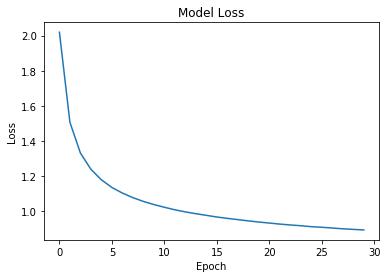

In [58]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure()
plt.plot(loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#pylab.xlim([0,60])
fig.savefig('loss.png')
plt.show();

In [59]:
model.save('model.h5')

In [60]:
dump(char_int_map, open('char_int_map.pkl', 'wb'))

In [61]:
type(model)

keras.models.Sequential

## Generating sequences

In [42]:
from pickle import load
from numpy import array
from keras.models import load_model
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [43]:
def gen_seq(model, char_int_map, n_seq, test_seq, size_gen):
    num_classes=len(char_int_map)
    txt = test_seq
    print(txt)
    # generate a fixed number of characters
    for i in range(size_gen):
        encoded = pad_sequences([[char_int_map[c] for c in txt]], 
                                maxlen=n_seq, truncating='pre')
        encoded = to_categorical(encoded, num_classes=num_classes)
        ypred = model.predict_classes(encoded)
        int_to_char = ''
        for c, idx in char_int_map.items():
            if idx == ypred:
                int_to_char = c
                break
        # append to input
        txt += int_to_char
    return txt

### Loading the model and the dictionary

In [44]:
# load the model
model = load_model('model.h5')
# load the mapping
char_int_map = load(open('char_int_map.pkl', 'rb'))

In [46]:
# test start of rhyme
print(gen_seq(model, char_int_map, 20, 'that which is self caused', 40))
print(gen_seq(model, char_int_map, 20, 'nature for instance a body', 40))

that which is self caused
that which is self caused by another modifications of the human b
nature for instance a body
nature for instance a body in the same as the constitution of the 


In [76]:
raw[0:400]

'part i concerning god definitions i by that which is self caused i mean that of which the essence involves existence or that of which the nature is only conceivable as existent ii a thing is called finite after its kind when it can be limited by another thing of the same nature for instance a body is called finite because we always conceive another greater body so also a thought is limited by anot'

### Correct

    1) "that which is self caused i mean that of which the essence"
    2) "nature for instance a body is called finite because we always conceive"

### Conclusion

The model has to learn better probably by increasing the number of epochs.